In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/hdd/home/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_dir" has conflict with protected namespace "model_".

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '10_09_24_Roads_Pilot_Inference'

options:
    verify_graceful_exit: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False
)

Finished loading inference stats.
Log amounts: log_root                                                            log_set                                              
/storage/vbutoi/scratch/ESE/inference/09_30_24_ISLES_3D_BigLTSEval  20240930_125830-CAQN-57ffc0d20ccfdb30ebb619e08cfd4165    300
                                                                    20240930_125835-11XO-6cca3b6e3c23fd796bc8780c67ea7e89    300
dtype: int64


/storage/vbutoi/projects/ESE/ese/analysis/analyze_inf.py:207: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  inference_df = pd.concat(inference_pd_collection, axis=0)


In [4]:
len(inference_df['data_id'].unique())

75

In [5]:
# for ikey in inference_df.keys():
#     print(ikey)

In [6]:
def pretrain_loss_fn(model_class, pretraining_loss_func_class, loss_func_class):
    m_name = model_class.split('.')[-1]
    loss_fn = loss_func_class.split('.')[-1]
    pre_loss_fn = pretraining_loss_func_class.split('.')[-1]
    # If it's a UNet, the pretrain loss func is just the loss func.
    if m_name == "UNet":
        if loss_fn == "SoftDiceLoss":
            parsed_pt_loss_fn = "SoftDice"
        elif loss_fn == "PixelCELoss":
            parsed_pt_loss_fn = "CrossEntropy"
        else:
            parsed_pt_loss_fn = loss_fn
    else:
        if pre_loss_fn == "SoftDiceLoss":
            parsed_pt_loss_fn = "SoftDice"
        elif pre_loss_fn == "PixelCELoss":
            parsed_pt_loss_fn = "CrossEntropy"
        else:
            parsed_pt_loss_fn = pre_loss_fn
    try:
        assert parsed_pt_loss_fn != "None"
        return parsed_pt_loss_fn
    except:
        print(m_name, loss_fn, parsed_pt_loss_fn)
        raise ValueError("Something went wrong")

def posthoc_loss_fn(model_class, loss_func_class):
    m_name = model_class.split('.')[-1]
    loss_fn = loss_func_class.split('.')[-1]
    # If it's a UNet, there was no posthoc stage.
    if m_name == "UNet":
        return "None"
    else:
        if loss_fn == "SoftDiceLoss":
            return "SoftDice"
        elif loss_fn == "PixelCELoss":
            return "CrossEntropy"
        else:
            return loss_fn

def log_dir(log_root, log_set):
    return f"{log_root}/{log_set}"

inference_df.augment(log_dir)
# inference_df.augment(pretrain_loss_fn)
inference_df.augment(posthoc_loss_fn)

In [7]:
# For the purpose of this experiment, we only care about a few columns in particular:
exp_columns = [
    "split",
    "data_id",
    "log_dir",
    "log_root",
    "model_class",
    "image_metric", # Important for looking at the performance of these networks.
    "metric_score", #
    "soft_proportion",
    "hard_proportion",
    "posthoc_loss_fn",
    # "pretrain_loss_fn",
    "new_gt_proportion", # This is after our resizing and blurring
    "experiment_model_dir",
    "experiment_pretrained_seed", 
    "model_pretrained_exp_root",
]
# Take these columns of the inference_df, drop other columns.
exp_df = inference_df[exp_columns].drop_duplicates().reset_index(drop=True)

# Library Funcs

In [8]:
def prepare_proportion_df(raw_df, groupby_keys, value_vars, var_name, value_name):
    # Make a clone of the proportion df.
    input_df = raw_df.copy()
    # Melt the dataframe to have a single column for the error.
    return pd.melt(
        input_df,
        id_vars=groupby_keys,
        value_vars=value_vars,
        var_name=var_name,
        value_name=value_name,
    )

def process_method_names(input_df, value_name):
    # Make a clone of the input_df
    df = input_df.copy()
    # Then we augment the proportion_type with the calibrator name.
    def proportion_type(calibrator, loss_func, proportion_type):
        if proportion_type in ["new gt error", "new gt relative error"]:
            return "New GT"
        elif calibrator == "None":
            return "None" + proportion_type.split(" ")[0] + f" ({loss_func})"
        else:
            return calibrator + " soft" + f" ({loss_func})"
    # Finally, sort by data_id
    df['proportion type'] = df.apply(lambda x: proportion_type(x['calibrator'], x['loss_func'], x['proportion_type']), axis=1)
    df = df.sort_values(by="data_id")
    # Drop the duplicate rows and reset the index.
    df = df.drop_duplicates().reset_index(drop=True)
    # Return the augmented dataframe.
    return df

# First, let's look at absolute error.

In [9]:
def calibration_method(log_root, model_class, experiment_model_dir):
    model_class_name = model_class.split('.')[-1]
    # If it is a UNet, it could be SVLS or Uncalibrated
    if model_class_name == "UNet":
        if "SVLS" in experiment_model_dir:
            return "SVLS"
        else:
            if "Thresh" in log_root:
                return "Thresh" 
            else:
                return "None" 
    else:
        if model_class_name == "LocalTS":
            return "LTS"
        elif model_class_name == "Popcorn_Scaling":
            return "Popcorn"
        elif model_class_name == "ImageBasedTS":
            return "IBTS"
        elif model_class_name == "Temperature_Scaling":
            return "TS"
        else:
            raise ValueError(f"Unknown model class: {model_class}")

exp_df.augment(calibration_method)

In [10]:
# Make some columns that are useful for plotting.
total_proportion_df = prepare_proportion_df(
    exp_df, 
    groupby_keys=[
        "calibration_method",
        "posthoc_loss_fn",
        # "pretrain_loss_fn",
        "image_metric", # Important for looking at the performance of these networks.
        "metric_score", #
        "log_dir",
        "split",
        "data_id", 
        "experiment_pretrained_seed", 
        "new_gt_proportion"
    ],
    value_vars=["soft_proportion", "hard_proportion"],
    var_name="prop_type",
    value_name="proportion"
)
# Delete duplicate rows, thought there shouldn't be any..
total_proportion_df = total_proportion_df.drop_duplicates().reset_index(drop=True)

def posthoc_method(calibration_method, posthoc_loss_fn):
    return f"{calibration_method},{posthoc_loss_fn}"

def estimator(calibration_method, prop_type):
    return f"{calibration_method} {prop_type.split('_')[0]}"

total_proportion_df.augment(estimator)
total_proportion_df.augment(posthoc_method)

In [11]:
# Some useful conversions for us.
total_proportion_df['# Foreground Pixels'] = total_proportion_df['proportion'] * (400**2)
total_proportion_df['new_gt_foreground_pixels'] = total_proportion_df['new_gt_proportion'] * (400**2)
total_proportion_df['gt_foreground_pixels'] = total_proportion_df['new_gt_foreground_pixels'] # We don't have a notion of "true" ground truth here.
# New error columns.
total_proportion_df['Absolute Area Error'] = (total_proportion_df['# Foreground Pixels'] - total_proportion_df['new_gt_foreground_pixels']).abs()
total_proportion_df["Relative Absolute Area Error"] = total_proportion_df["Absolute Area Error"] / total_proportion_df["new_gt_foreground_pixels"]

In [12]:
# THIS CELL FILTERS THE DF DOWN TO THE PARAMETERS OF OUR EXPERIMENT.
estimator_list = [
    "None hard",
    "None soft",
    "LTS soft",
]

# Filter the area estimator.
proportion_df = total_proportion_df[total_proportion_df['estimator'].isin(estimator_list)].reset_index(drop=True).sort_values(by="gt_foreground_pixels")
# Finally, we want to change the order that the methods appear in.
# These are the unique values of the estimator column.
proportion_df['split'] = proportion_df['split'].astype('category')
proportion_df['split'] = proportion_df['split'].cat.reorder_categories([
    'cal',
    'val'
])
proportion_df['estimator'] = proportion_df['estimator'].astype('category')
proportion_df['estimator'] = proportion_df['estimator'].cat.reorder_categories(estimator_list)

In [13]:
# THIS CELL IS THE COLOR PALLETE
estimator_palette = {
    'None hard': 'tab:blue',
    'None soft': 'tab:green',
    "LTS soft": 'tab:red',
}

## Plotting Data_ID vs Method for a Variety of Methods.

<ipython-input-14-2939a5af1859>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


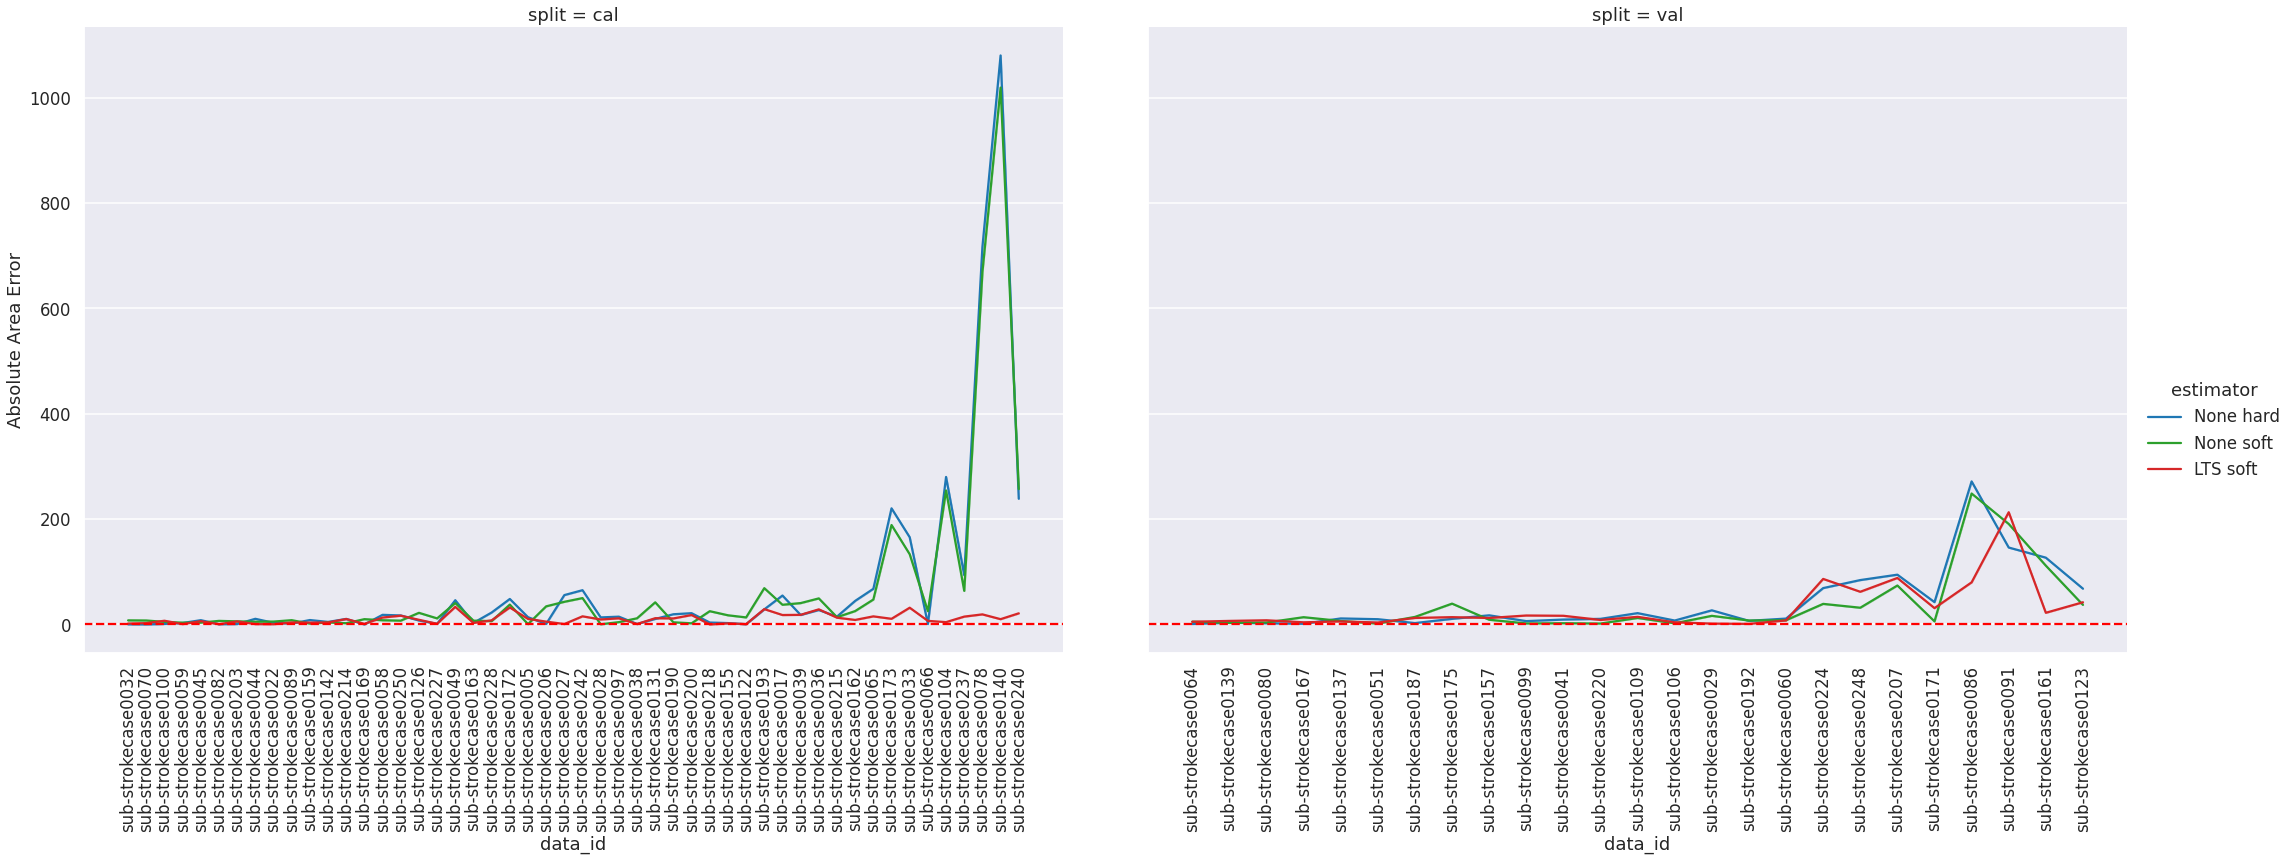

In [14]:
g = sns.relplot(
    proportion_df, 
    x="data_id",
    y="Absolute Area Error",
    hue="estimator",
    kind="line",
    col="split",
    height=10,
    aspect=1.5,
    palette=estimator_palette,
    facet_kws={'sharex': False}
)
# We want to add, per x data_id a dot that represents the gt_proportion.
for ax in g.axes.flat:
    # Add it to this ax
    # Add a horizontal red dashed line at y = 0
    ax.axhline(0, color='red', linestyle='dashed')
# Disable horizontal grid lines for every subplot
for ax in g.axes.flat:
    ax.xaxis.grid(False)
    # Rotate the x ticks by 90 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Set the y axis to be the same as the downsized plot.
plt.show()

In [15]:
# Get the average absolute area error for each estimator. for each split
avg_area_error = proportion_df.groupby(['split', 'estimator']).mean().reset_index()

<ipython-input-15-06ea30c2fe15>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_area_error = proportion_df.groupby(['split', 'estimator']).mean().reset_index()


In [16]:
avg_area_error[['split', 'estimator', 'Absolute Area Error']]

,split,estimator,Absolute Area Error
0,cal,None hard,69.832086
1,cal,None soft,67.187681
2,cal,LTS soft,10.252000
3,val,None hard,42.492070
4,val,None soft,35.527966
5,val,LTS soft,30.724449


In [17]:
avg_area_error[['split', 'estimator', 'Relative Absolute Area Error']]

,split,estimator,Relative Absolute Area Error
0,cal,None hard,0.276591
1,cal,None soft,0.341558
2,cal,LTS soft,0.173347
3,val,None hard,0.266573
4,val,None soft,0.317123
5,val,LTS soft,0.340814
